In [42]:
%pylab inline
import cv2
import numpy as np
import dicom
import pandas as pd

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [43]:
img_001 = cv2.imread('referenceData/MIAS/mdb001.pgm', cv2.IMREAD_UNCHANGED)
print img_001.shape
print img_001.dtype

(1024, 1024)
uint8


In [44]:
print img_001.mean()
print img_001.max()
print img_001.min()

36.5348396301
221
0


In [45]:
img_info_df = pd.read_csv('referenceData/MIAS/mammogram_info.csv', sep=" ")
img_info_df.head()

,Reference,Bkg,Class,Sever,X,Y,Rad
0,mdb001,G,CIRC,B,535,425,197
1,mdb002,G,CIRC,B,522,280,69
2,mdb003,D,NORM,NaN,NaN,NaN,NaN
3,mdb004,D,NORM,NaN,NaN,NaN,NaN
4,mdb005,F,CIRC,B,477,133,30


In [46]:
img_malign_df = img_info_df.loc[img_info_df['Sever'] == 'M']
print img_malign_df.shape
img_malign_df.head()

(54, 7)


,Reference,Bkg,Class,Sever,X,Y,Rad
23,mdb023,G,CIRC,M,538,681,29
28,mdb028,F,CIRC,M,338,314,56
58,mdb058,D,MISC,M,318,359,27
72,mdb072,G,ASYM,M,266,517,28
75,mdb075,F,ASYM,M,468,717,23


In [47]:
img_info_df['Rad'].describe()

count    119.000000
mean      48.848739
std       33.558863
min        3.000000
25%       27.000000
50%       41.000000
75%       61.500000
max      197.000000
Name: Rad, dtype: float64

In [48]:
img_malign_df['Rad'].describe()

count     51.000000
mean      56.705882
std       32.435964
min       13.000000
25%       31.000000
50%       49.000000
75%       71.000000
max      174.000000
Name: Rad, dtype: float64

In [49]:
img_info_df['Bkg'].describe()

count     330
unique      3
top         D
freq      117
Name: Bkg, dtype: object

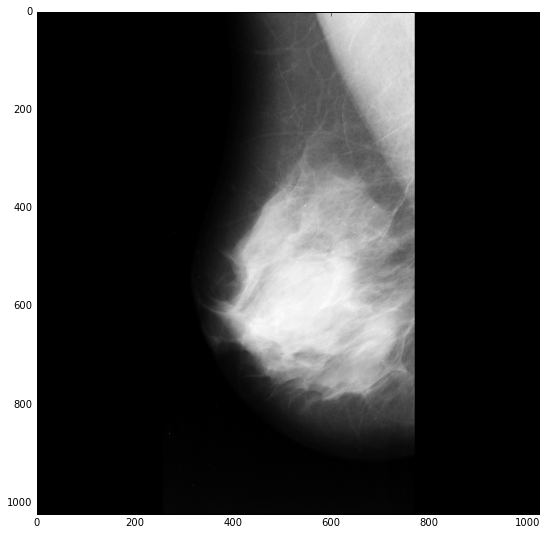

In [50]:
fig,ax = subplots()
fig.set_size_inches([9, 9])
ax.imshow(img_001, cmap='gray')

In [51]:
img_info_df_indexed = img_info_df.set_index('Reference')
img_info_df_indexed.head()

,Bkg,Class,Sever,X,Y,Rad
Reference,,,,,,
mdb001,G,CIRC,B,535,425,197
mdb002,G,CIRC,B,522,280,69
mdb003,D,NORM,NaN,NaN,NaN,NaN
mdb004,D,NORM,NaN,NaN,NaN,NaN
mdb005,F,CIRC,B,477,133,30


In [52]:
img_001_info = img_info_df_indexed.loc['mdb001']
img_001_info

Bkg         G
Class    CIRC
Sever       B
X         535
Y         425
Rad       197
Name: mdb001, dtype: object

In [53]:
x1 = int(img_001_info['X']) - int(img_001_info['Rad'])
y1 = 1024 - int(img_001_info['Y']) - int(img_001_info['Rad'])
x2 = int(img_001_info['X']) + int(img_001_info['Rad'])
y2 = 1024 - int(img_001_info['Y']) + int(img_001_info['Rad'])
print x1, y1
print x2, y2

338 402
732 796


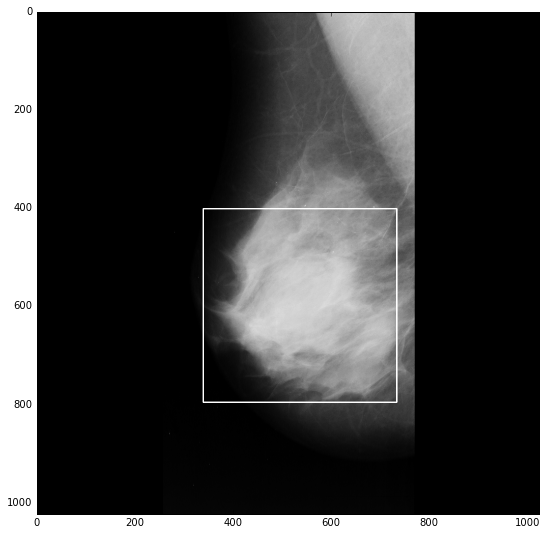

In [54]:
# cv2.imshow(img_001)
img_001_rect = cv2.rectangle(img_001, (x1, y1), (x2, y2), (255,255,255), 2)
fig,ax = subplots()
fig.set_size_inches([9, 9])
ax.imshow(img_001_rect, cmap='gray')

In [55]:
rad = img_info_df_indexed['Rad'].copy()
rad.sort_values(ascending=True).head(10)

Reference
mdb212     3
mdb223     6
mdb226     7
mdb218     8
mdb226     8
mdb227     9
mdb248    10
mdb214    11
mdb211    13
mdb236    14
Name: Rad, dtype: float64

In [65]:
print sum(img_info_df_indexed['Class'] == 'NORM')
print sum(img_info_df_indexed['Class'] != 'NORM')

207
123


In [104]:
def show_roi(ref, folder, df, r=None, n=0):
    from os import path
    img = cv2.imread(path.join(folder, ref + '.pgm'), cv2.IMREAD_UNCHANGED)
    info = df.loc[ref]
    try:
        xc = int(info['X'])
        yc = int(info['Y'])
        if r is None:
            r = int(info['Rad'])
    except TypeError:
        xc = int(info['X'].iloc[n])
        yc = int(info['Y'].iloc[n])
        if r is None:
            r = int(info['Rad'].iloc[n])
    x1 = xc - r
    y1 = 1024 - yc - r
    x2 = xc + r
    y2 = 1024 - yc + r
    
    img_roi = cv2.rectangle(img, (x1, y1), (x2, y2), (255,255,255), 2)
    fig,ax = subplots()
    fig.set_size_inches([9, 9])
    ax.imshow(img_roi, cmap='gray')

In [103]:
int(img_info_df_indexed.loc['mdb144']['X'].iloc[0])

233

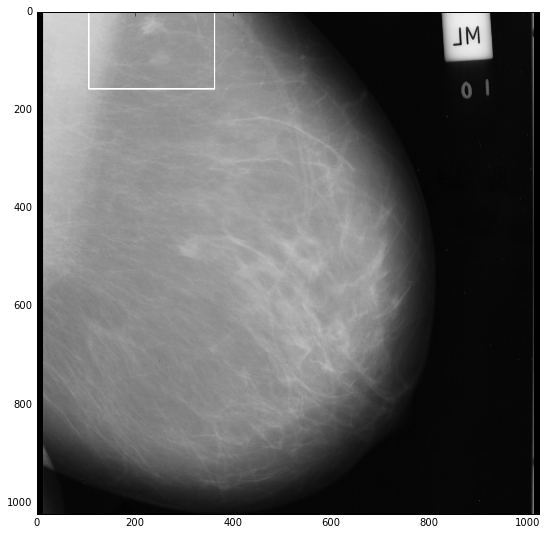

In [108]:
show_roi('mdb144', 'referenceData/MIAS', img_info_df_indexed, 128, n=0)

In [99]:
from os import path
rs = 128  # ROI radius size.
roi_cnt = 0
outdir = 'referenceData/MIAS/roi'

def clip(v, minv=0, maxv=1024):
    v = minv if v < minv else v
    v = maxv if v > maxv else v
    return v
    
for ref, info in img_info_df_indexed.iterrows():
    try:
        xc = int(info['X'])
        yc = int(info['Y'])
        r = int(info['Rad'])
    except ValueError:
        continue
    img = cv2.imread(path.join('referenceData/MIAS', ref + '.pgm'), cv2.IMREAD_UNCHANGED)
    if r <= rs:
        x = xc - rs
        x = clip(x)
        y = 1024 - yc - rs
        y = clip(y)
        roi = img[y:y+rs*2, x:x+rs*2]
        patch = np.zeros((rs*2, rs*2))
        patch[0:roi.shape[0], 0:roi.shape[1]] = roi
        fn = "%s_roi%04d.png" % (ref, roi_cnt)
        cv2.imwrite(path.join(outdir, fn), patch, [cv2.IMWRITE_PNG_COMPRESSION, 0])
        roi_cnt += 1
    else:
        xss = [-r, -rs, r-2*rs]
        yss = [-r, -rs, r-2*rs]
        for xs in xss:
            for ys in yss:
                x = xc + xs
                x = clip(x)
                y = 1024 - yc + ys
                y = clip(y)
                roi = img[y:y+rs*2, x:x+rs*2]
                patch = np.zeros((rs*2, rs*2))
                patch[0:roi.shape[0], 0:roi.shape[1]] = roi
                fn = "%s_roi%04d.png" % (ref, roi_cnt)
                cv2.imwrite(path.join(outdir, fn), patch, [cv2.IMWRITE_PNG_COMPRESSION, 0])
                roi_cnt += 1
print roi_cnt

151


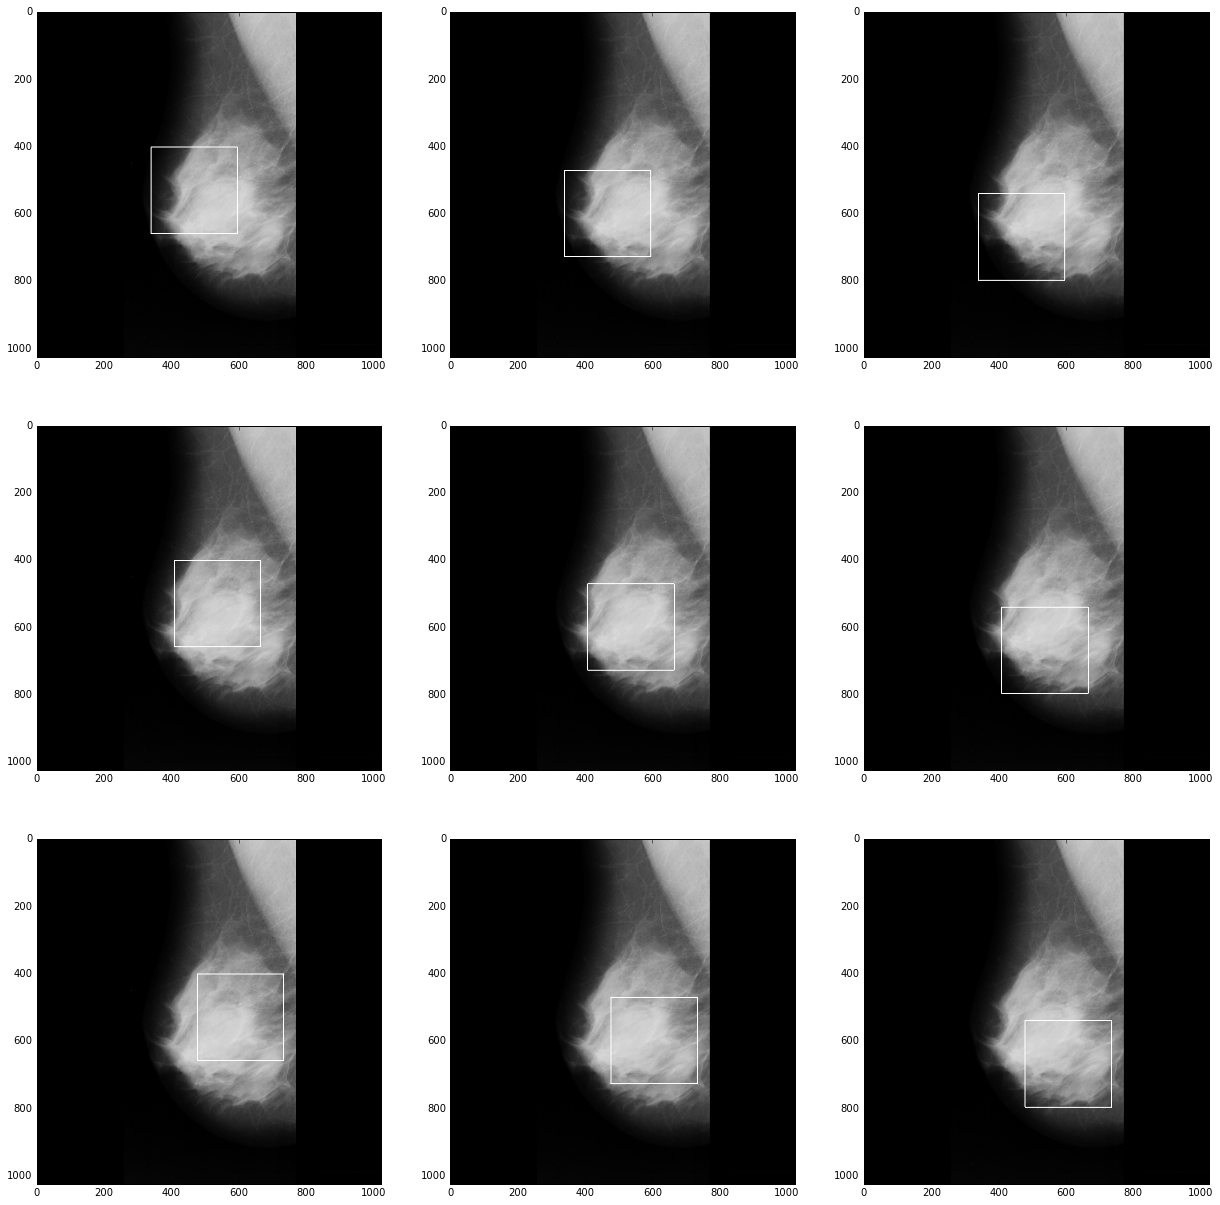

In [95]:
fig,axes = subplots(3, 3)
fig.set_size_inches([21, 21])
rs = 128  # ROI radius size.
info = img_info_df_indexed.loc['mdb001']
try:
    xc = int(info['X'])
    yc = int(info['Y'])
    r = int(info['Rad'])
except ValueError:
    pass
img = cv2.imread(path.join('referenceData/MIAS', 'mdb001' + '.pgm'), cv2.IMREAD_UNCHANGED)
if r <= rs:
    x = xc - rs
    y = 1024 - yc - rs
    roi = img[y:y+rs*2, x:x+rs*2]
    fn = "%s_roi%04d.png" % (ref, roi_cnt)
    cv2.imwrite(path.join(outdir, fn), roi, [cv2.IMWRITE_PNG_COMPRESSION, 0])
else:
    xss = [-r, -rs, r-2*rs]
    yss = [-r, -rs, r-2*rs]
    for i, xs in enumerate(xss):
        for j, ys in enumerate(yss):
            x = xc + xs
            y = 1024 - yc + ys
            img_roi = cv2.rectangle(img.copy(), (x, y), (x+2*rs, y+2*rs), (255,255,255), 2)
            axes[i, j].imshow(img_roi, cmap='gray')

In [33]:
img_norm = cv2.imread('referenceData/MIAS/mdb003.pgm', cv2.IMREAD_UNCHANGED)
ret,th = cv2.threshold(img_norm, 13, 255, cv2.THRESH_BINARY)

In [34]:
th_, contours, hierarchy = cv2.findContours(th.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

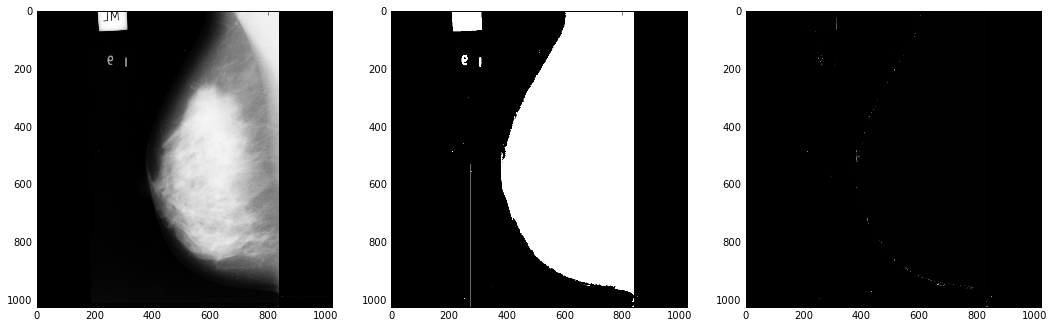

In [35]:
fig,axes = subplots(1, 3)
fig.set_size_inches([18, 6])
axes[0].imshow(img_norm, cmap='gray')
axes[1].imshow(th, cmap='gray')
axes[2].imshow(th_, cmap='gray')

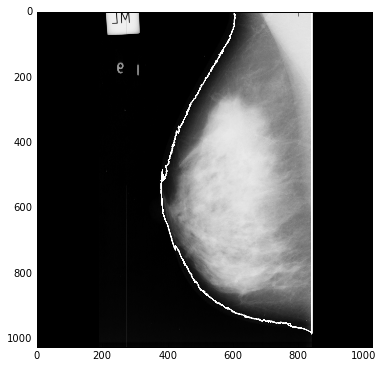

In [36]:
cont = cv2.drawContours(img_norm.copy(), contours, 60, (255,255,255), 3)
fig,ax = subplots()
fig.set_size_inches([6, 6])
ax.imshow(cont, cmap='gray')

In [105]:
cont_areas = [cv2.contourArea(c_) for c_ in contours]
np.argmax(cont_areas)

NameError: name 'contours' is not defined

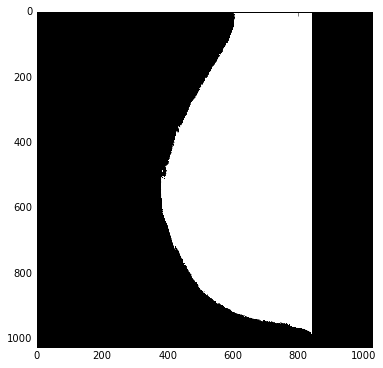

In [39]:
breast_mask = cv2.drawContours(np.zeros_like(th), contours, 60, 255, cv2.FILLED)
fig,ax = subplots()
fig.set_size_inches([6, 6])
ax.imshow(breast_mask, cmap='gray')

In [40]:
cv2.boundingRect(contours[60])

(378, 1, 460, 983)

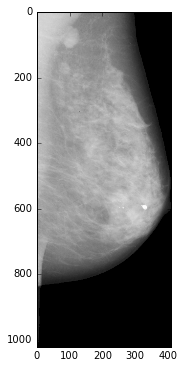

In [85]:
from dm_preprocess import DMImagePreprocessor as IMP
img = cv2.imread('referenceData/MIAS/mdb270.pgm', cv2.IMREAD_UNCHANGED)
img_breast = IMP.segment_breast(img, .1)
fig,ax = subplots()
fig.set_size_inches([6, 6])
ax.imshow(img_breast, cmap='gray')

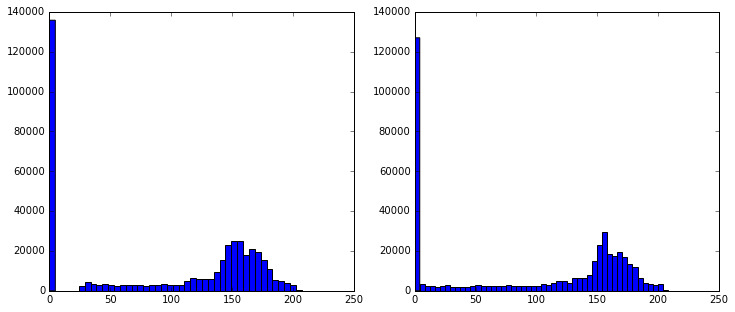

In [86]:
img_breast_blur = cv2.GaussianBlur(img_breast.copy(), (41, 41), 0)
fig,axes = subplots(1, 2)
fig.set_size_inches([12, 5])
_ = axes[0].hist(img_breast.ravel(), 50)
_ = axes[1].hist(img_breast_blur.ravel(), 50)

In [87]:
ret,th = cv2.threshold(img_breast, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
print ret

81.0


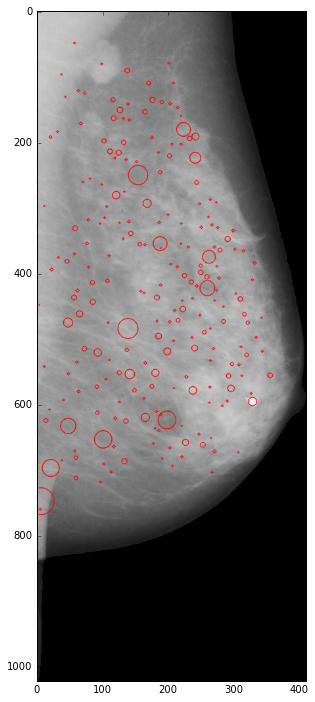

In [93]:
# Set up the detector with default parameters.
params = cv2.SimpleBlobDetector_Params()
params.filterByArea = True
params.minArea = 3
params.maxArea = 256**2
params.filterByCircularity = False
params.filterByColor = False
params.filterByConvexity = False
params.filterByInertia = False
params.minThreshold = 125
params.maxThreshold = 220
params.thresholdStep = 10
detector = cv2.SimpleBlobDetector_create(params)

# Detect blobs.
keypoints = detector.detect(img_breast)
 
# Draw detected blobs as red circles.
# cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS ensures the size of the circle 
# corresponds to the size of blob
im_with_keypoints = cv2.drawKeypoints(
    img_breast.copy(), keypoints, np.array([]), 255, 
    cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
fig,axes = subplots(1, 1)
fig.set_size_inches([8, 12])
#axes[0].imshow(img_breast, cmap='gray')
axes.imshow(im_with_keypoints, cmap='gray')

In [96]:
print len(keypoints)
print params.minThreshold
print params.maxThreshold
print params.thresholdStep

219
125.0
220.0
10.0


In [104]:
kp = keypoints[0]
print kp.pt
print kp.size

(96.25, 718.25)
3.0
0


In [107]:
from os import path
from dm_preprocess import DMImagePreprocessor as IMP
from numpy.random import RandomState

rng = RandomState(12345)
rs = 128  # ROI radius size.
bkg_cnt = 0
outdir = 'referenceData/MIAS/bkg'
low_th = .1
roi_th = .5
nb_sample = 16

params = cv2.SimpleBlobDetector_Params()
params.filterByArea = True
params.minArea = 3
params.maxArea = (rs*2)**2
params.filterByCircularity = False
params.filterByColor = False
params.filterByConvexity = False
params.filterByInertia = False
params.minThreshold = int(roi_th*255)
params.maxThreshold = 220
params.thresholdStep = 10
detector = cv2.SimpleBlobDetector_create(params)

def clip(v, minv=0, maxv=1024):
    v = minv if v < minv else v
    v = maxv if v > maxv else v
    return v
    
for ref, info in img_info_df_indexed.iterrows():
    is_norm = info['Class'] == 'NORM'
    if not is_norm:
        continue
    img = cv2.imread(path.join('referenceData/MIAS', ref + '.pgm'), cv2.IMREAD_UNCHANGED)
    img = IMP.segment_breast(img, low_th)
    # Detect blobs.
    keypoints = detector.detect(img)
    if len(keypoints) > nb_sample:
        keypoints = rng.choice(keypoints, nb_sample, replace=False)
    for kp in keypoints:
        xc, yc = kp.pt
        x = xc - rs
        x = clip(x)
        y = yc - rs
        y = clip(y)
        roi = img[y:y+rs*2, x:x+rs*2]
        patch = np.zeros((rs*2, rs*2))
        patch[0:roi.shape[0], 0:roi.shape[1]] = roi
        fn = "%s_bkg%04d.png" % (ref, bkg_cnt)
        cv2.imwrite(path.join(outdir, fn), patch, [cv2.IMWRITE_PNG_COMPRESSION, 0])
        bkg_cnt += 1
print bkg_cnt

/Users/lishen/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:47: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


3312
